In [556]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import random
import scipy 
from scipy.spatial.distance import pdist , cdist

import matplotlib.pyplot as plt
 
from math import sin, cos, sqrt, atan2, radians
 
import pickle
import os 
import sys
import math


In [557]:
parent_dir = sys.path[0]
 

data_depot = pd.read_csv(os.path.join(parent_dir, 'data/data_depot.csv'))
data_client_index = pd.read_csv(os.path.join(parent_dir, 'data/data_clients.csv'))


with open(os.path.join(parent_dir,'data/distance_matrix.pickle'), 'rb') as handle:
    distance_matrix = pickle.load(handle)

with open(os.path.join(parent_dir,'data/times.pickle'), 'rb') as handle:
    times = pickle.load(handle)


In [48]:
import folium

# Calculer les coordonnées de latitude et de longitude moyennes des clients pour centrer la carte
latitude = data_client_index['CUSTOMER_LATITUDE'].mean()
longitude = data_client_index['CUSTOMER_LONGITUDE'].mean()

# Créer une carte centrée sur les coordonnées moyennes
carte = folium.Map(location=[latitude, longitude], zoom_start=10)

# Ajouter des marqueurs pour chaque client

# Ajouter des marqueurs et des segments pour chaque client
for i in range(len(data_client_index)):
    # Ajouter un marqueur pour le client
    client = data_client_index.iloc[i]
    folium.Marker(location=[client['CUSTOMER_LATITUDE'], client['CUSTOMER_LONGITUDE']], popup=str(i)).add_to(carte)

    # Si ce n'est pas le dernier client dans la liste, ajouter un segment reliant ce client au client suivant
    if i < len(data_client_index) - 1:
        client_suivant = data_client_index.iloc[i + 1]
        folium.PolyLine(locations=[[client['CUSTOMER_LATITUDE'], client['CUSTOMER_LONGITUDE']], [client_suivant['CUSTOMER_LATITUDE'], client_suivant['CUSTOMER_LONGITUDE']]], color='red').add_to(carte)

# Enregistrer la carte dans un fichier HTML
carte.save('carte_clients.html')


c:\Users\hicha\anaconda3\envs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\hicha\anaconda3\envs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='a', ylabel='count'>

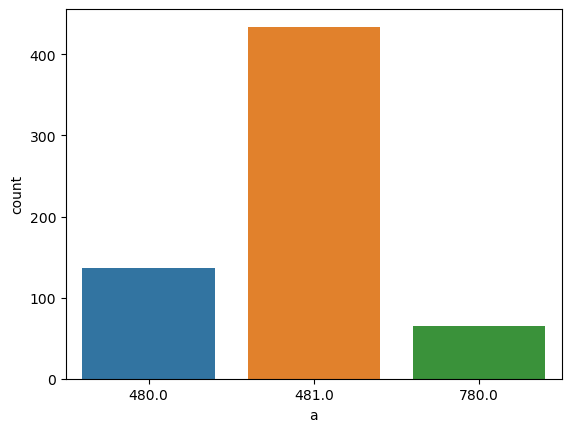

In [77]:
import seaborn as sns
sns.countplot(data_client_index['b'])
sns.countplot(data_client_index['a'])

In [192]:
# Calculer la distance entre chaque paire de points
from geopy import distance
taille_m = len(data_client_index)
distance_matrix = np.zeros((taille_m, taille_m))
for i, row_i in data_client_index.iterrows():
    for j, row_j in data_client_index.iterrows():
        if i != j:
            coord_i = (row_i['CUSTOMER_LATITUDE'], row_i['CUSTOMER_LONGITUDE'])
            coord_j = (row_j['CUSTOMER_LATITUDE'], row_j['CUSTOMER_LONGITUDE'])
            dist = distance.distance(coord_i, coord_j).km
            distance_matrix[i, j] = dist

In [288]:
CUSTOMER_DELIVERY_SERVICE_TIME = data_client_index['d'].values
TOTAL_WEIGHT_KG = data_client_index['TOTAL_WEIGHT_KG'].values
CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT = data_depot['TIME_DISTANCE_MIN'].values
CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT = data_depot['DISTANCE_KM'].values


In [286]:
def choix_client_suivant(client_potentiel,client_courant,methode):
        
    if methode==0:
            client_suivant = random.choice(client_potentiel)
     
    if methode==1:
            client_potentiel_distance = [distance_matrix[client_courant,client] for client in client_potentiel]
            client_suivant = client_potentiel[client_potentiel_distance.index(min(client_potentiel_distance))]

    return(client_suivant)

In [1002]:
def get_route_by_car(client_disponible,Q,V_moy,time_window):
    solution = []
    t = 480
    total_weight = 0
    i=0

    client_courant = 0
    client_potentiel = client_disponible

    # chosir le client le plus proche de depot
 
    client_suivant = random.choice(client_potentiel)

    
    t = t +  CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[client_suivant] + CUSTOMER_DELIVERY_SERVICE_TIME[client_suivant]
    total_weight = total_weight+TOTAL_WEIGHT_KG[client_suivant]
    if total_weight<Q and t<time_window:
        solution.append(client_suivant)
    
     
     
    client_disponible.remove(client_suivant)

    client_courant = client_suivant
    client_potentiel = [client for client in client_disponible if  t+distance_matrix[client_courant,client]/V_moy < time_window and total_weight+TOTAL_WEIGHT_KG[client]<Q]
    i=1
    
    while len(client_potentiel)>0:
        
        client_suivant = random.choice(client_potentiel)
         
        solution.append(client_suivant)
        client_disponible.remove(client_suivant)
        

        t = t + distance_matrix[client_courant,client_suivant]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[client_suivant]
        total_weight = total_weight+TOTAL_WEIGHT_KG[client_suivant]
        client_courant = client_suivant
 
        client_potentiel = [client for client in client_disponible if  t+distance_matrix[client_courant,client]/V_moy < time_window and total_weight+TOTAL_WEIGHT_KG[client]<Q]
        i+=1
    return(solution)
 

In [1003]:
def get_route_version0(Q,V_moy,time_window):
    client_disponible = [i for i in range(len(data_client_index))]
    Global_route = []
    k=0
    while len(client_disponible)>0:
        route_by_car = get_route_by_car(client_disponible,Q,V_moy,time_window)
        Global_route.append(route_by_car)
        client_disponible = [client for client in  client_disponible if client not in route_by_car]
    
    print('nombre des voitures utilisées ',len(Global_route))
    return(Global_route)

In [1004]:
Q = 5000
V_moy=60
time_window = 950
global_route = get_route_version0(Q,V_moy,time_window)
cout(global_route)

nombre des voitures utilisées  20


28965.483115776093

In [581]:
import random

# Définir les couleurs que vous voulez utiliser pour les voitures
couleurs_voitures = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF']

# Créer une carte centrée sur les coordonnées moyennes
carte = folium.Map(location=[latitude, longitude], zoom_start=10)

# Ajouter des marqueurs et des segments pour chaque client et chaque voiture
for i, clients in enumerate(global_route[:2]):
    # Générer une couleur aléatoire pour chaque voiture
    couleur = random.choice(couleurs_voitures)

    # Ajouter un marqueur pour chaque client
    for j, client in enumerate(clients):
        client_data = data_client_index.iloc[client]
        folium.Marker(location=[client_data['CUSTOMER_LATITUDE'], client_data['CUSTOMER_LONGITUDE']],
                      popup=str(client),
                      icon=folium.Icon(color=couleur)).add_to(carte)

        # Si ce n'est pas le dernier client visité par la voiture, ajouter un segment reliant ce client au client suivant
        if j < len(clients) - 1:
            client_suivant = clients[j + 1]
            client_suivant_data = data_client_index.iloc[client_suivant]
            folium.PolyLine(locations=[[client_data['CUSTOMER_LATITUDE'], client_data['CUSTOMER_LONGITUDE']],
                                       [client_suivant_data['CUSTOMER_LATITUDE'], client_suivant_data['CUSTOMER_LONGITUDE']]],
                            color=couleur).add_to(carte)


# Enregistrer la carte dans un fichier HTML
carte.save('carte_clients.html')



C:\Users\hicha\AppData\Local\Temp\ipykernel_120\1776759628.py:19: UserWarning: color argument of Icon should be one of: {'pink', 'orange', 'purple', 'lightred', 'red', 'black', 'cadetblue', 'lightblue', 'darkgreen', 'white', 'green', 'lightgreen', 'blue', 'gray', 'darkblue', 'lightgray', 'darkred', 'darkpurple', 'beige'}.
  icon=folium.Icon(color=couleur)).add_to(carte)


In [582]:
def cout(global_route):
    cout = 0
    for route in global_route:
       
        cout_depot_depart = CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT[route[0]]
        cout_depot_retour = CUSTOMER_DELIVERY_SERVICE_DISTANCE_FROM_DEPOT[route[-1]]
        cout = cout+sum([distance_matrix[route[i],route[i+1]] for i in range(len(route)-1)])+cout_depot_retour+cout_depot_depart

    return(cout+len(global_route))

In [701]:
 def get_route_version1(list_client,time_window,Q):
    Global_route = []
    client_numbre = len(list_client)
    client_visited = 0

    while  client_visited<client_numbre:

        client_disponible = list_client[client_visited:]
        route_by_car = []
        t = 480+CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[client_disponible[0]]+CUSTOMER_DELIVERY_SERVICE_TIME[client_disponible[0]]
        weight = TOTAL_WEIGHT_KG[client_disponible[0]]
         
         
        i=0
        while t<time_window and weight<Q:

            route_by_car.append(client_disponible[i])
            i+=1
            if i>=len(client_disponible):
                break
            t = t+distance_matrix[client_disponible[i-1],client_disponible[i]]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[client_disponible[i]]
            weight +=TOTAL_WEIGHT_KG[client_disponible[i]]
 
        client_visited+=i
        Global_route.append(route_by_car)
        
         

    return(Global_route)
            

In [620]:
matrice_temps_Cij= np.zeros((len(data_client_index)+1,len(data_client_index)+1))
for i in range(len(data_client_index)+1):
    for j in range(len(data_client_index)+1):
        if j==i:
            matrice_temps_Cij[i,j]=0
        elif i==0 or j ==0:
            matrice_temps_Cij[i,j] = CUSTOMER_DELIVERY_SERVICE_TIME_FROM_DEPOT[max(i,j)-1]+CUSTOMER_DELIVERY_SERVICE_TIME[max(i,j)-1]
        else:
            matrice_temps_Cij[i,j] = distance_matrix[i-1,j-1]/V_moy + CUSTOMER_DELIVERY_SERVICE_TIME[j-1]

In [1015]:
import pickle

with open('matrice_temps_Cij.pickle', 'wb') as handle:
    pickle.dump(matrice_temps_Cij, handle, protocol=pickle.HIGHEST_PROTOCOL)



array([[  0.        , 138.73      ,  71.972     , ...,  55.004     ,
         34.628     , 134.272     ],
       [138.73      ,   0.        ,  22.05474381, ...,   9.31370517,
          9.50118257,  11.01094544],
       [ 71.972     ,   8.53474381,   0.        , ...,   9.42058138,
          9.97203899,  10.53258665],
       ...,
       [ 55.004     ,   8.49370517,  22.12058138, ...,   0.        ,
          9.79099484,  10.905945  ],
       [ 34.628     ,   8.20118257,  22.19203899, ...,   9.31099484,
          0.        ,  11.13713799],
       [134.272     ,   9.22094544,  22.26258665, ...,   9.935945  ,
         10.64713799,   0.        ]])

In [759]:
def get_route_version2(list_client,time_window,Q):
    arret = [0]
    i=0
    while i<len(list_client):
        weight = TOTAL_WEIGHT_KG[list_client[i]]
        time = 480+matrice_temps_Cij[0,list_client[i]+1]

        while time<time_window and weight<Q: 
            i+=1
            if i > len(list_client)-1:
                break
            time+=matrice_temps_Cij[list_client[i-1]+1,list_client[i]+1]
            weight+= TOTAL_WEIGHT_KG[list_client[i]]
             
        arret.append(i)
      
    
    Global_route =[list_client[arret[k]:arret[k+1]] for k in range(len(arret)-1)]
    return(Global_route)

# RS

In [706]:
def Voisinnage(T):
    
    n = len(T)
    i = np.random.randint(n)
    j = np.random.randint(n)
    T[j] = i
    T[i] = j
    return(T)

In [1009]:
def Voisinnage(T):
    
    n = len(T)
    i = np.random.randint(n)
    j = np.random.randint(n)
    T[j] = i
    T[i] = j
    return(T)
    
def recuit_simule(initial_state,  temperature_initiale=1.0, temperature_finale=1e-8, alpha=0.99):

    """Implémente l'algorithme de recuit simulé."""

    history = []
    current_state = initial_state
    current_energy = cout(get_route_version2(current_state,time_window,Q))
    best_state = current_state
    best_energy = current_energy
    temperature = temperature_initiale
    i=0
    bete=1
    while temperature > temperature_finale:
        
         
        new_state =  Voisinnage(current_state.copy())
        new_energy = cout(get_route_version2(new_state,time_window,Q))
        delta_energy = new_energy - current_energy
        if i==0:
            beta = abs(- delta_energy / (temperature * math.log(0.66)))
            i=1

          

        if delta_energy < 0 or math.exp(-delta_energy / beta*temperature) <random.random():
        
            current_state = new_state
            current_energy = new_energy

        if current_energy < best_energy:
            best_state = current_state
            best_energy = current_energy

        temperature *= alpha

        history.append(best_energy)

    #print('best_energy : '  , best_energy)
    #print('new state : '  , current_state)


    return best_state, best_energy , history

In [1010]:
list_client_initial = [i for i in range(len(data_client_index))]
random.shuffle(list_client)
best_state, best_energy , history = recuit_simule(list_client_initial,  temperature_initiale=4.0, temperature_finale=1e-8, alpha=0.99)

best_energy :  15856.12378469949
new state :  [144, 427, 359, 310, 193, 501, 202, 433, 243, 112, 172, 79, 380, 79, 376, 15, 448, 251, 263, 314, 572, 84, 384, 23, 246, 25, 229, 39, 165, 319, 263, 62, 302, 431, 69, 543, 540, 43, 185, 27, 437, 120, 203, 404, 196, 390, 456, 75, 51, 550, 350, 397, 52, 486, 65, 209, 501, 194, 31, 268, 486, 150, 548, 63, 388, 232, 551, 140, 458, 34, 210, 470, 141, 332, 82, 275, 87, 286, 86, 199, 80, 315, 74, 382, 21, 358, 78, 351, 136, 569, 81, 148, 186, 473, 357, 385, 568, 210, 98, 544, 391, 101, 333, 492, 570, 350, 366, 295, 386, 130, 198, 378, 391, 203, 19, 379, 306, 293, 158, 550, 430, 326, 64, 283, 300, 149, 389, 323, 183, 487, 231, 32, 58, 156, 36, 294, 516, 297, 557, 215, 67, 72, 455, 206, 0, 45, 491, 149, 91, 147, 409, 160, 62, 85, 507, 461, 133, 215, 371, 159, 151, 396, 172, 402, 67, 28, 214, 84, 570, 348, 308, 254, 65, 423, 358, 455, 85, 161, 262, 247, 417, 497, 265, 533, 186, 323, 92, 364, 209, 254, 305, 4, 482, 4, 57, 195, 44, 290, 411, 296, 294, 

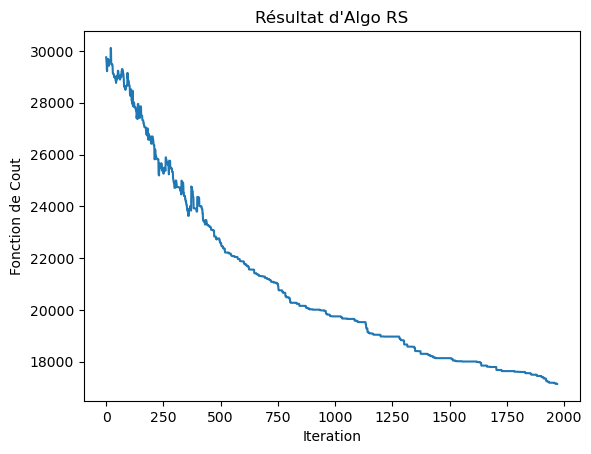

In [997]:
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Fonction de Cout')
plt.title("Résultat d'Algo RS")
plt.savefig('Algo_RS')

# Genetique

In [795]:
def valid(solution):
    for i in range(len(solution)):
        if i not in solution:
            return False
    return(True)

def valid_pop(pop):
    for sol in pop:
        if not valid(sol):
            return(False)
    return(True)

In [1011]:


import copy
# Définition de la fonction de sélection par tournoi
def selection(Couts, taille_tournoi):
    participants = random.sample(Couts.keys(), taille_tournoi)
    return min(participants, key=lambda x:Couts[x] )

# Définition de la fonction de croisement à un point
import random

def croisement(parent1, parent2):
    # Point de croisement aléatoire
    croisement_point = random.randint(1, len(parent1) - 1)

    # Croisement

    enfant1 = copy.deepcopy(parent1[:croisement_point]) +copy.deepcopy(parent2[croisement_point:])
    enfant2 = copy.deepcopy(parent2[:croisement_point]) + copy.deepcopy(parent1[croisement_point:])
    
    # Correction de la répétition des éléments
    enfant_r1 = []
    for element in enfant1 :
        if enfant1.count(element) > 1 and element not in enfant_r1:
            enfant_r1.append(element)
    enfant_r2 = []
    for element in enfant2 :
        if enfant2.count(element) > 1 and element not in enfant_r2:
            enfant_r2.append(element)
    
    
    
    if len(enfant_r2)!=0:
        for i in range(len(enfant_r2)):
            enfant2[enfant2.index(enfant_r2[i])],enfant1[enfant1.index(enfant_r1[i])] = enfant_r1[i] , enfant_r2[i]
    
    return enfant1, enfant2


# Définition de la fonction de mutation
def mutation(solution, taux_mutation):

    if random.random() < taux_mutation : 

        n = len(solution)
        i = np.random.randint(n)
        j = np.random.randint(n)
        solution[j],solution[i] = solution[i],solution[j]
    

    return(solution)
         
# Définition de l'algorithme génétique
def genetique(population, taux_mutation, max_iterations):
    history = []
    taille_population = len(population)
    best_cout = float("inf")
    best_element = None

    for i in range(max_iterations):
        Couts = {k: cout(get_route_version2(population[k], time_window, Q)) for k in range(taille_population)}
        parents = [population[selection(Couts, 2)] for j in range(taille_population)]
        history.append(min(list(Couts.values())))
        
        enfants = []
        for j in range(0, taille_population, 2):
            enfants1, enfants2 = croisement(parents[j], parents[j+1])
            enfants.append(enfants1)
            enfants.append(enfants2)

        population = [mutation(enfants[j], taux_mutation) for j in range(taille_population)]
        
        for k in range(taille_population):
            cout_k = cout(get_route_version2(population[k], time_window, Q))
            if cout_k < best_cout:
                best_cout = cout_k
                best_element = population[k]

    return best_element, best_cout, history

# Exemple d'utilisation
population = []
list_client_initial = [i for i in range(len(data_client_index))]
for j in range(50): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    population.append(x)

taux_mutation = 0.05
max_iterations = 200
best_element, best_cout, history = genetique(population, taux_mutation, max_iterations)
 

C:\Users\hicha\AppData\Local\Temp\ipykernel_120\2491246541.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  participants = random.sample(Couts.keys(), taille_tournoi)


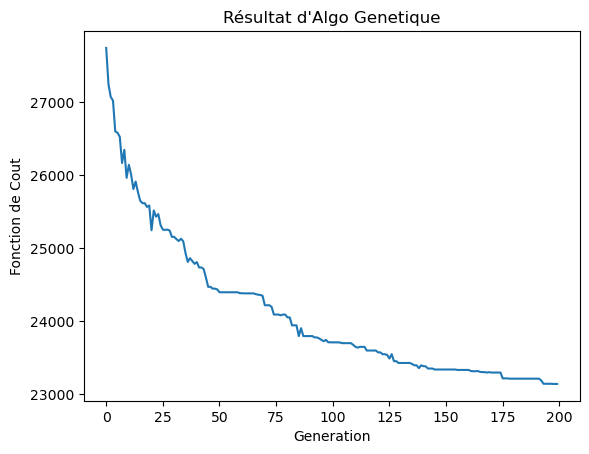

In [1012]:
plt.plot(history)
plt.xlabel('Generation')
plt.ylabel('Fonction de Cout')
plt.title("Résultat d'Algo Genetique")
plt.savefig('Algo_Genetique')

# Tabou

In [1013]:
import random


# Définition de la fonction de voisinage
def voisinage(solution):
    voisin = solution.copy()
    i = random.randint(0, len(solution) - 1)  # Sélection d'un élément au hasard
    j = random.randint(0, len(solution) - 1)  # Sélection d'un autre élément au hasard
    voisin[i], voisin[j] = voisin[j], voisin[i]  # Échange des deux éléments
    return voisin

# Définition de l'algorithme Tabou
def tabou(liste_initiale, taille_tabou, max_iterations,n_voisin):
    
    history = []
    meilleure_solution = liste_initiale
    meilleure_valeur = cout(get_route_version2(meilleure_solution,time_window,Q))
    liste_tabou = []
    for i in range(max_iterations):
        

        for i in range(n_voisin):
            voisin = voisinage(meilleure_solution)
            while voisin in liste_tabou:  # Si le voisin est dans la liste tabou, on en génère un autre
                voisin = voisinage(meilleure_solution)

            if i==0:
                valeur_meilleur_voisin = cout(get_route_version2(voisin,time_window,Q))
                meilleur_voisin = voisin
            else:
                s = cout(get_route_version2(voisin,time_window,Q))
                if s<valeur_meilleur_voisin:
                    meilleur_voisin = voisin
                    valeur_meilleur_voisin = s

            
        # on passe au meilleur voisin trouvé de la solution courantes
        meilleure_solution = meilleur_voisin
        meilleure_valeur = valeur_meilleur_voisin
            
            
        liste_tabou.append(meilleure_solution)  # On ajoute le voisin dans la liste tabou
        if len(liste_tabou) > taille_tabou:  # Si la taille de la liste tabou dépasse la taille maximale autorisée
            liste_tabou.pop(0)  # On supprime le premier élément de la liste tabou
            
        history.append(meilleure_valeur)
         
        
       
        
    return meilleure_solution, meilleure_valeur , history

# Exemple d'utilisation
list_client_initial = [i for i in range(len(data_client_index))]
taille_tabou = 30
max_iterations = 1000
meilleure_solution, meilleure_valeur , history = tabou(list_client_initial, taille_tabou, max_iterations,10)
print("Meilleure solution :", meilleure_solution)
print("Meilleure valeur :", meilleure_valeur)

Meilleure solution : [396, 500, 516, 535, 4, 361, 164, 537, 12, 559, 10, 447, 66, 13, 282, 475, 16, 75, 232, 495, 67, 530, 497, 479, 121, 363, 474, 169, 525, 445, 405, 546, 85, 130, 570, 314, 120, 284, 389, 39, 491, 529, 98, 391, 493, 211, 200, 275, 7, 49, 238, 463, 481, 53, 250, 166, 572, 416, 40, 32, 50, 181, 466, 192, 467, 331, 159, 219, 221, 408, 245, 142, 456, 48, 287, 150, 76, 165, 191, 382, 59, 409, 544, 406, 182, 56, 459, 156, 369, 350, 99, 256, 69, 124, 94, 423, 558, 303, 42, 354, 465, 505, 189, 206, 511, 176, 96, 30, 128, 338, 386, 462, 1, 113, 342, 341, 116, 534, 45, 368, 385, 301, 43, 127, 168, 318, 352, 288, 84, 244, 248, 383, 522, 436, 272, 105, 201, 103, 138, 97, 203, 473, 431, 143, 207, 174, 478, 106, 148, 149, 71, 151, 152, 517, 154, 155, 434, 477, 158, 348, 527, 400, 519, 399, 6, 246, 81, 89, 294, 281, 569, 171, 227, 489, 547, 311, 336, 58, 27, 175, 270, 162, 273, 269, 360, 532, 533, 15, 496, 223, 427, 186, 410, 422, 194, 258, 0, 313, 202, 199, 208, 83, 61, 480, 204, 

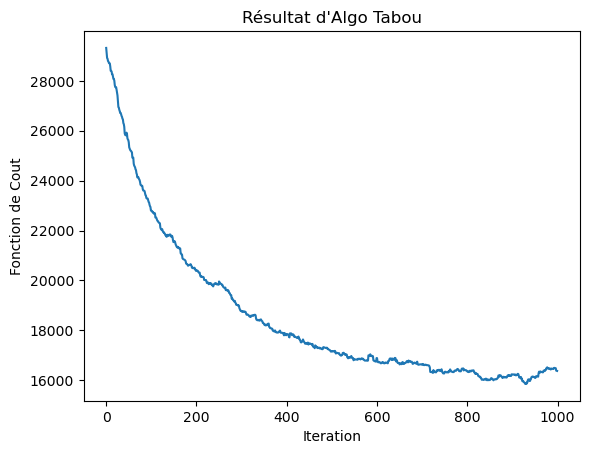

In [1014]:
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Fonction de Cout')
plt.title("Résultat d'Algo Tabou")
plt.savefig('Algo_Tabou')